In [4]:
%matplotlib inline

from pathlib import Path

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns

import networkx as nx
import sys

import genome_dist as gd

from sklearn.manifold import TSNE


import logging


import yaml
logging.basicConfig(level=logging.INFO)

In [5]:
atlas_version = "v2.17"
with open('../atlas_output_files.yaml') as file:
    files = yaml.safe_load(file)[atlas_version]


data_dir = Path("../DiarrheaExample/")

for key1, value1 in files.items():
    if isinstance(value1, str):
        # It's a direct path
        files[key1] = str(data_dir / value1)
    elif isinstance(value1, dict):
        # It's a nested dictionary, go deeper
        for key2, value2 in value1.items():
            files[key1][key2] = str(data_dir/ value2)



In [6]:
bin_info = pd.read_table(files["vamb"]["bin_info"], index_col=0)

#bin2genome = pd.read_table(files["genomes"]["bin2genome"], index_col=0)

bin2species = pd.read_table(files["vamb"]["bin2species"], index_col=0)

bin_info = bin_info.join(bin2species)
del bin2species

In [7]:
vamb_bins= bin_info.reset_index().genome.str.extract(r"^(?P<sample>.+)_vamb_(?P<bingroup>G[1234])(?P<vamb_bin>\d+)$")
bin_info["BinGroup"] = vamb_bins["bingroup"].values
bin_info["VambBin"] = vamb_bins.eval("bingroup + vamb_bin").values

#bin_info["VambBin"]= bin_info.index.map(lambda s: int(s.split("vamb_")[1]))

In [8]:
## Compare to vamb bin



bin_info.groupby(["Species","VambBin","BinGroup"]).size().to_frame().reset_index().groupby(["BinGroup","Species"]).size().value_counts()

Series([], Name: count, dtype: int64)

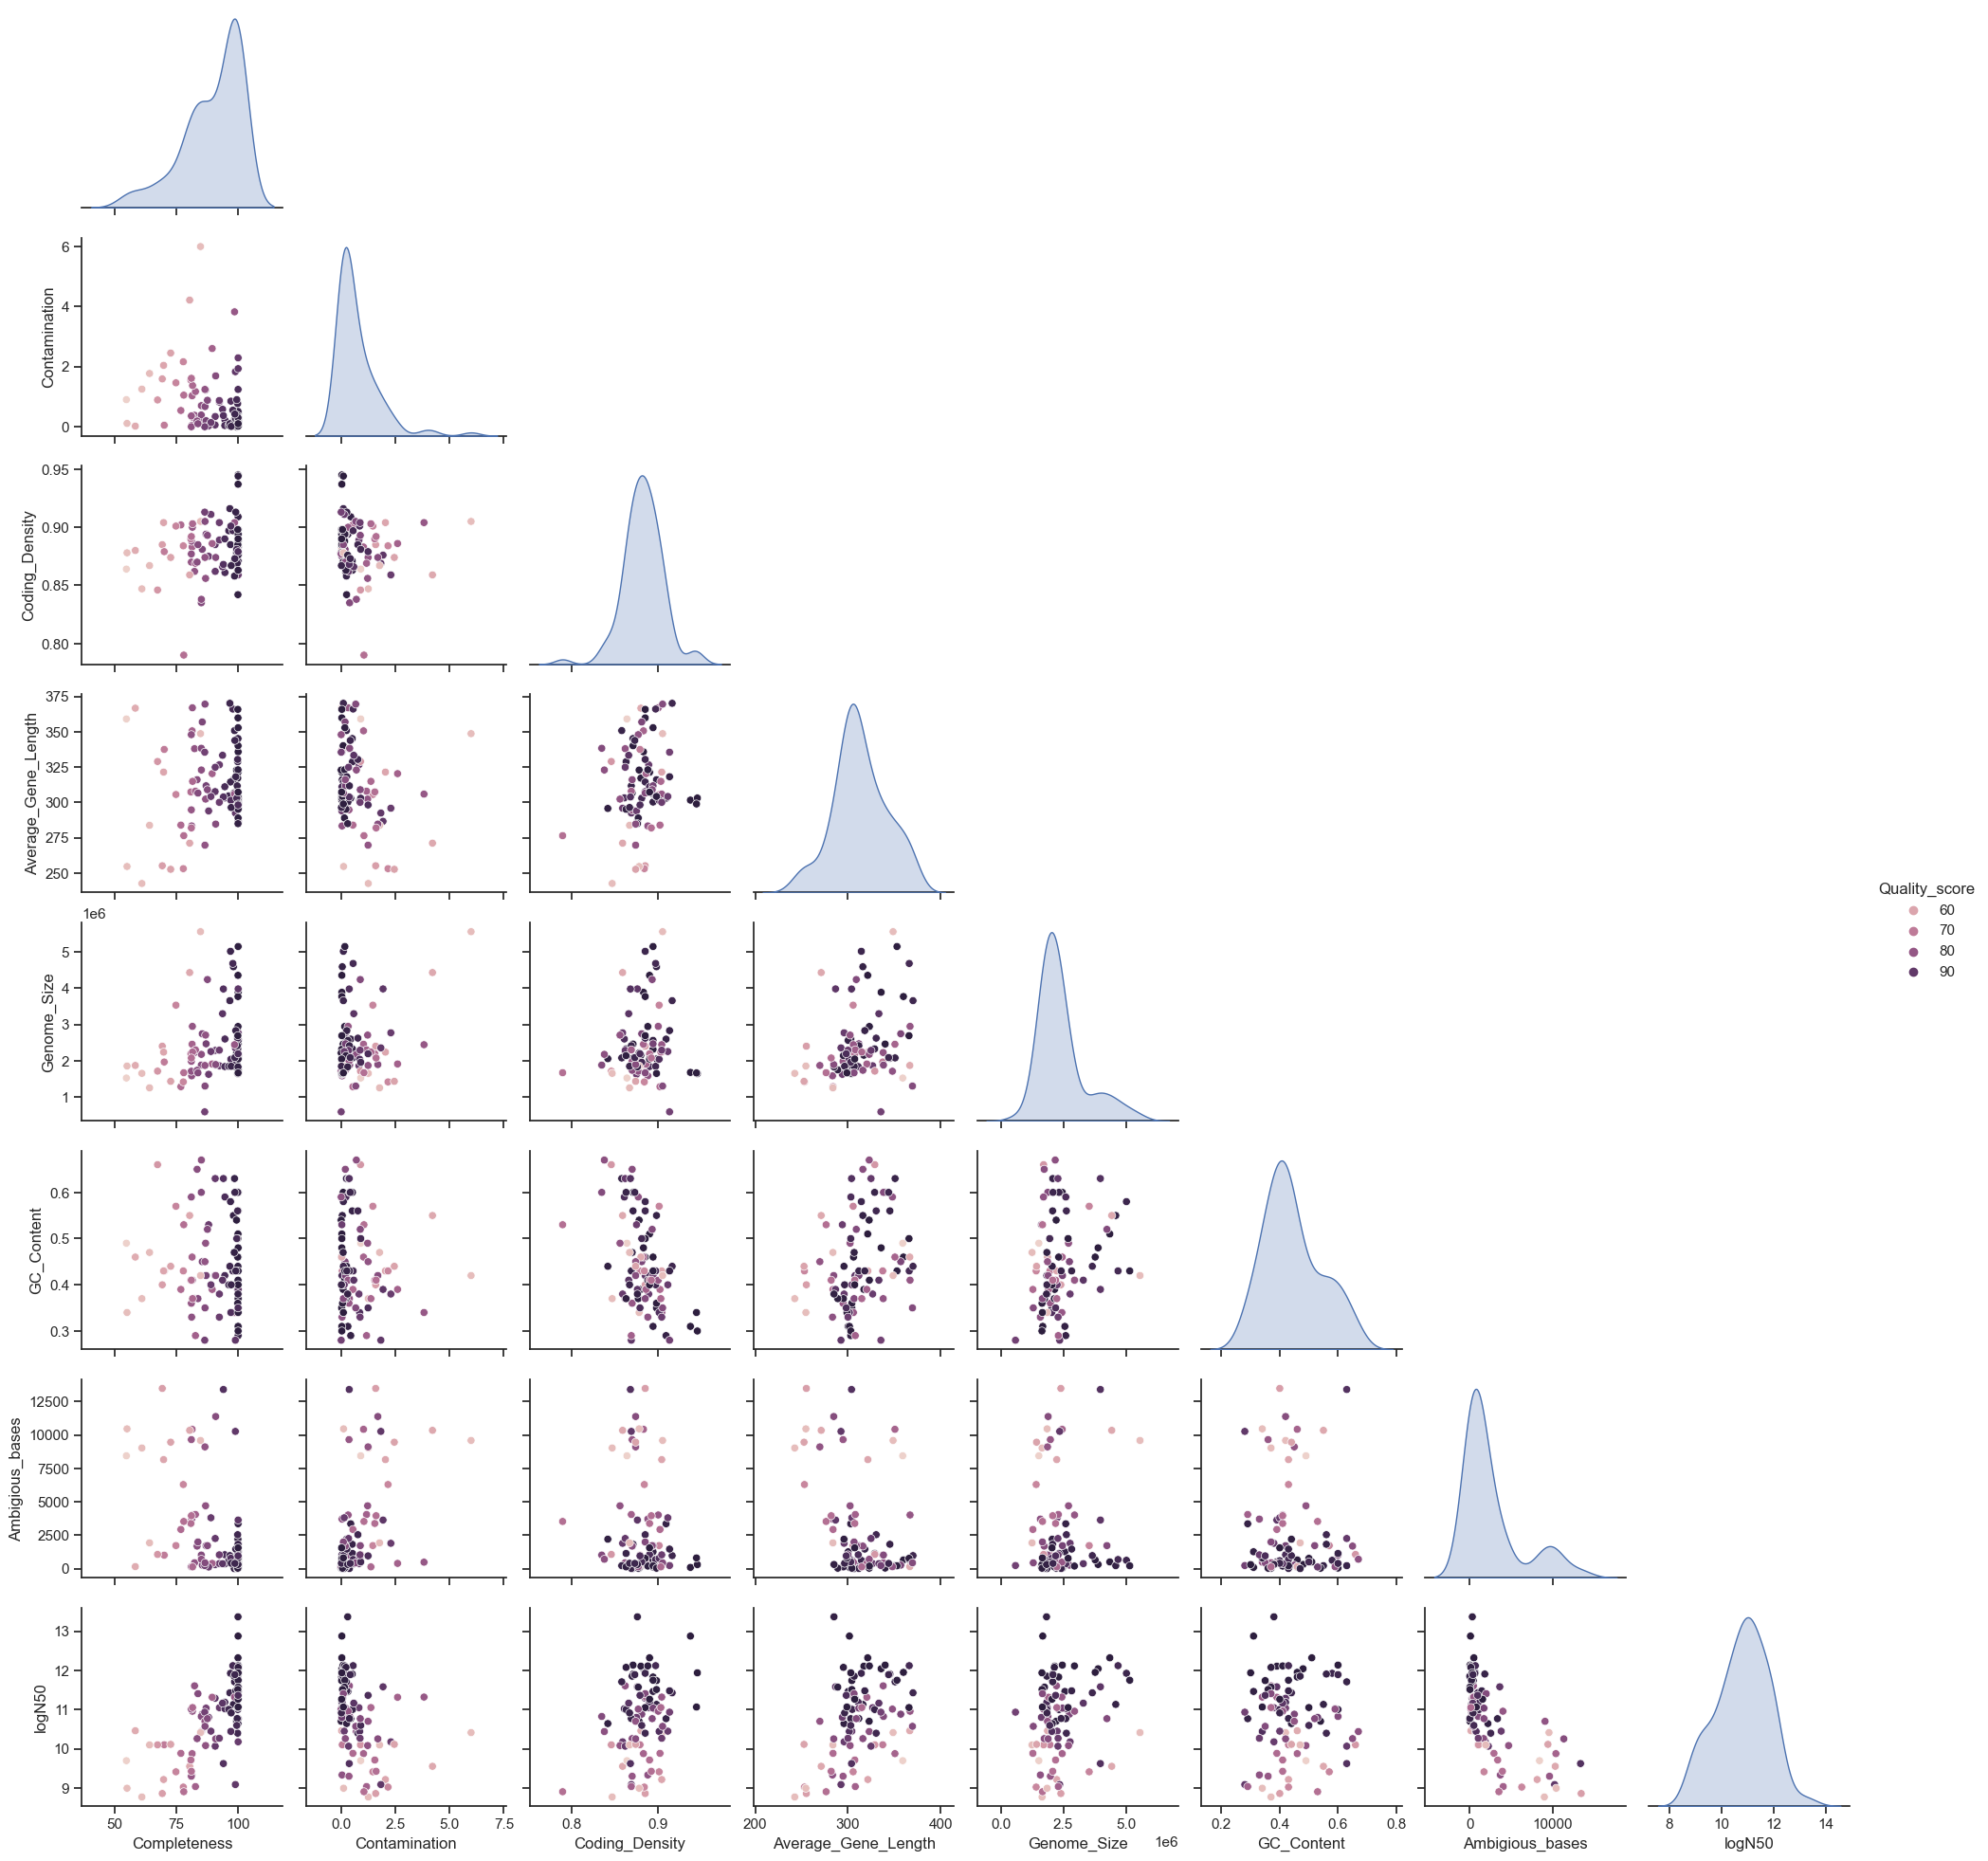

In [9]:
metric_columns= ['Completeness', 'Contamination',
        'Coding_Density', #'Contig_N50',
       'Average_Gene_Length', 'Genome_Size', 'GC_Content',
       #'Total_Coding_Sequences', 
       'Quality_score', 
       'Ambigious_bases', 'logN50']

sns.set_theme(style="ticks")
sns.pairplot(bin_info.loc[bin_info.Representative.unique(), metric_columns ],corner=True,hue="Quality_score",diag_kws=dict(hue=None))

<Axes: xlabel='Contamination', ylabel='Completeness'>

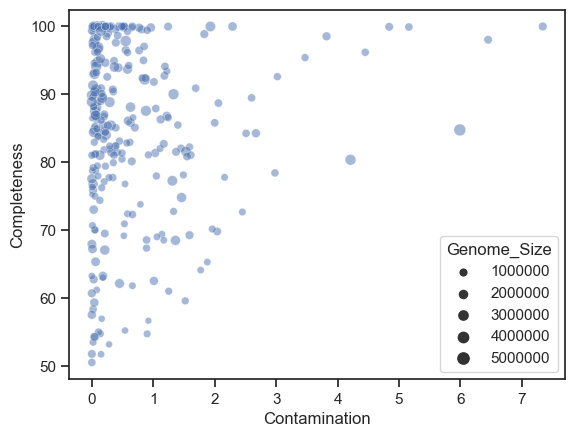

In [10]:
sns.scatterplot(data= bin_info, y="Completeness", x="Contamination", size="Genome_Size", alpha=0.5)

(50.0, 102.0)

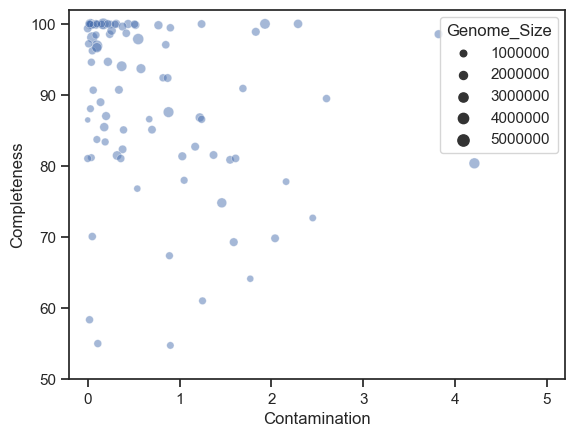

In [11]:
ax= sns.scatterplot(data= bin_info.loc[bin_info.Representative.unique() ], y="Completeness", x="Contamination", size="Genome_Size", alpha=0.5)

delta=0.2
ax.set_xlim(0-delta,5+delta)
ax.set_ylim(50,100+delta*10)

In [12]:
#bin_info.Quality_score.hist(cumulative=True)

#bin_info.loc[bin_info.Representative.unique() ].Quality_score.hist(cumulative=True)


In [13]:
M= gd.load_skani(files["vamb"]["similarities"])

In [14]:
# drop labels that are not in the bin_info
for level in range(2):

    index = M.index.levels[level]
    categories_to_drop = index.categories.difference(bin_info.index)

    M.drop(categories_to_drop,axis=0, level=level, inplace=True)

In [15]:
M["Align_fraction_min"] = M[["Align_fraction_ref","Align_fraction_query"]].min(axis=1)
M.eval("Align_fraction_diff = abs( Align_fraction_ref - Align_fraction_query) ", inplace=True)

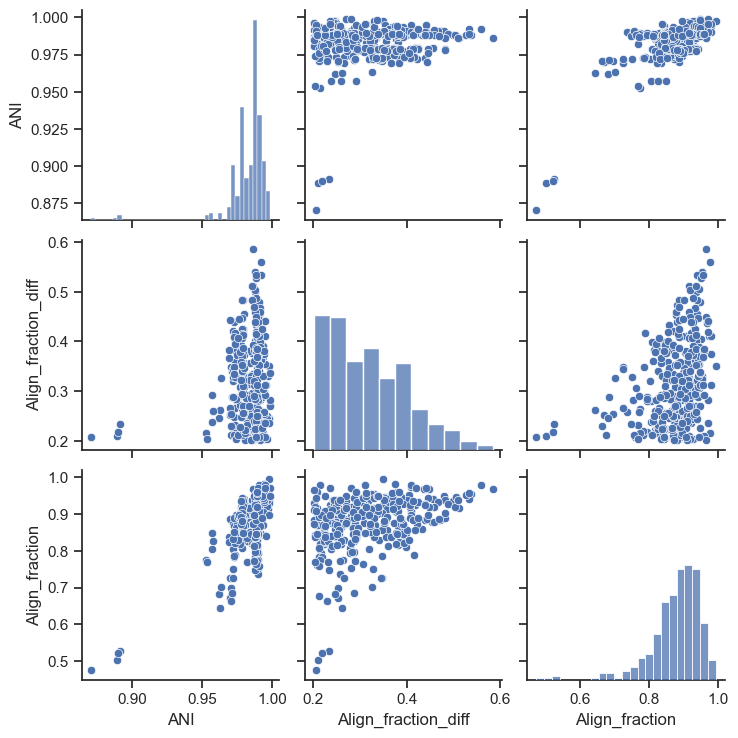

In [16]:
sns.pairplot(M.query("Align_fraction_diff > 0.2")[["ANI", "Align_fraction_diff", "Align_fraction"]],)

In [17]:
## Fix problemeatic genome distances

#pd.Series(M.query("Align_fraction_diff > 0.2").index.to_frame().values.ravel() ).value_counts()

bad_pairing_genomes= set()

for pair in M.query("Align_fraction_diff > 0.2").sort_values("Align_fraction_diff", ascending=False).index:

    if pair[0] in bad_pairing_genomes or pair[1] in bad_pairing_genomes:
        continue
    else:

        small_genome= bin_info.loc[list(pair),"Completeness"].idxmin()


        comp_small= bin_info.loc[small_genome,"Completeness"]

        if comp_small >= 90:
            print(f"Do not drop genome {small_genome} because it has completeness {comp_small} genomes have {M.loc[pair,'ANI']:.3f} ANI")
            #display(bin_info.loc[list(pair),"Completeness"])

        else:

            bad_pairing_genomes.add(small_genome)


In [18]:
pair= ( 'F117-W6_vamb_G23259', 'M252-W1_vamb_G3108823')


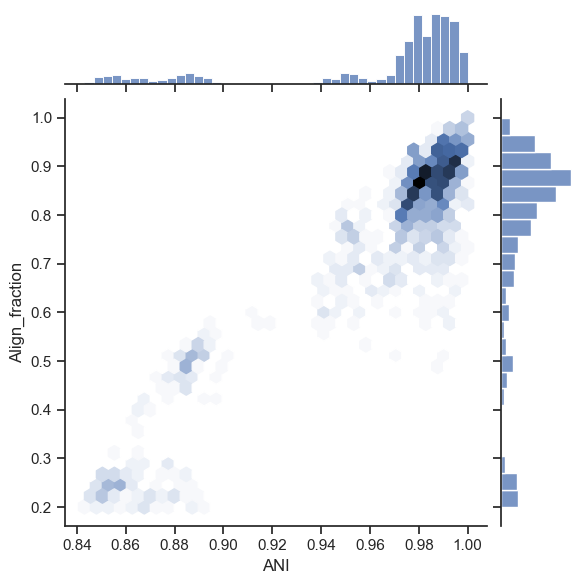

In [19]:
sns.jointplot(data=M, x= "ANI",y="Align_fraction", kind='hex')

plt.show()

#sns.scatterplot(data=M, x= "ANI",y="Align_fraction_min")

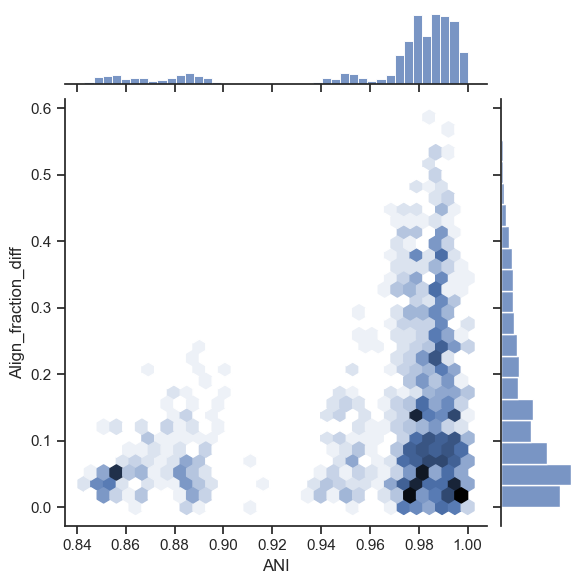

In [20]:
sns.jointplot(data=M, x= "ANI",y="Align_fraction_diff",kind="hex")

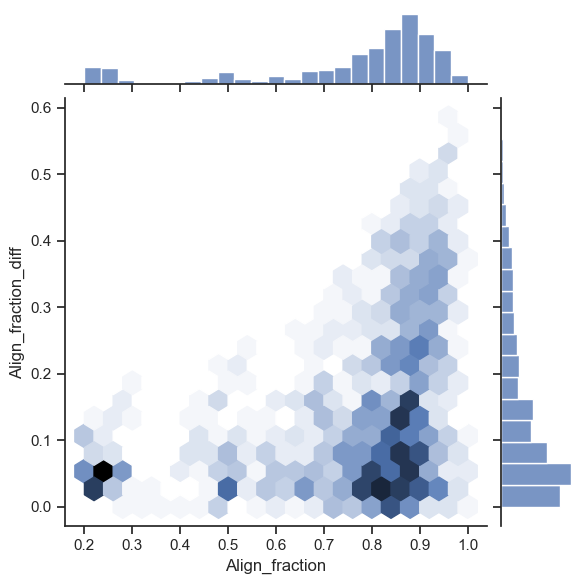

In [21]:
sns.jointplot(data=M, x= "Align_fraction",y="Align_fraction_diff",kind="hex")

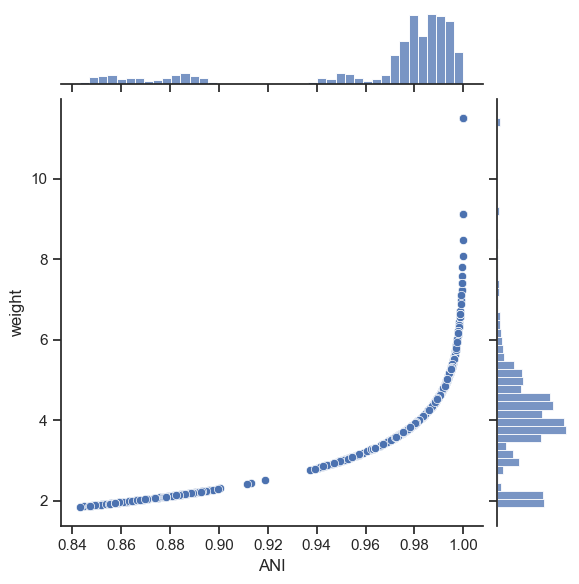

In [22]:
M.eval("weight= - log(1+1e-5-ANI)", inplace=True)

sns.jointplot(M, y="weight",x="ANI")

# Graph


In [23]:




M["Label"]= (M.ANI*100).map("{:.0f}%".format)

G= gd.to_graph(M,attributes= list(M.columns))

In [24]:
for node_att in [ 'Genome_Size',  'Quality_score',  'Species',
       'Representative']:

    node_att_dict = bin_info[node_att].to_dict()
    nx.set_node_attributes(G, node_att_dict, name=node_att)

In [25]:
pos= nx.layout.spring_layout(G,weight="weight")

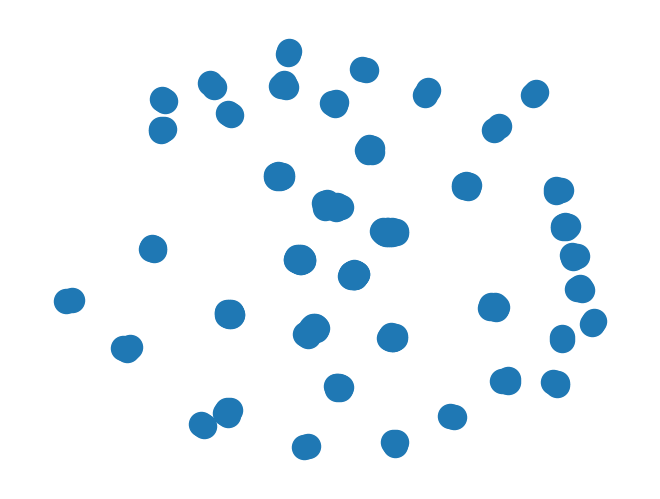

In [26]:
nx.draw(G,pos=pos)#,node_color=colors)
nx.draw_networkx_edges(G,pos=pos)

# TSNE / UMAP

In [27]:
representatives= bin_info.Representative.unique()
non_singleton_representatives = bin_info.loc[:,"Representative"].value_counts().loc[lambda x: x>2].index

non_singleton_bins= bin_info.index[bin_info.Representative.isin(non_singleton_representatives)]

In [28]:
Dist= 1- gd.pairewise2matrix(M.ANI,M.ANI.min()*0.65)

Dist= Dist.loc[non_singleton_bins,non_singleton_bins]

#sns.heatmap(Dist)

In [29]:
#embedder= TSNE(metric="precomputed",init="random", random_state=0)

import umap

# Perform UMAP
embedder = umap.UMAP(metric="precomputed")


XT = embedder.fit_transform(Dist)

XT = pd.DataFrame(XT, index=Dist.index, columns=["TSNE 1","TSNE 2"])


c:\Users\rdkiesersi1\AppData\Local\miniconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\rdkiesersi1\AppData\Local\miniconda3\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\rdkiesersi1\AppData\Local\miniconda3\lib\site-packages\umap\d

41  representatives are singletons and not in M

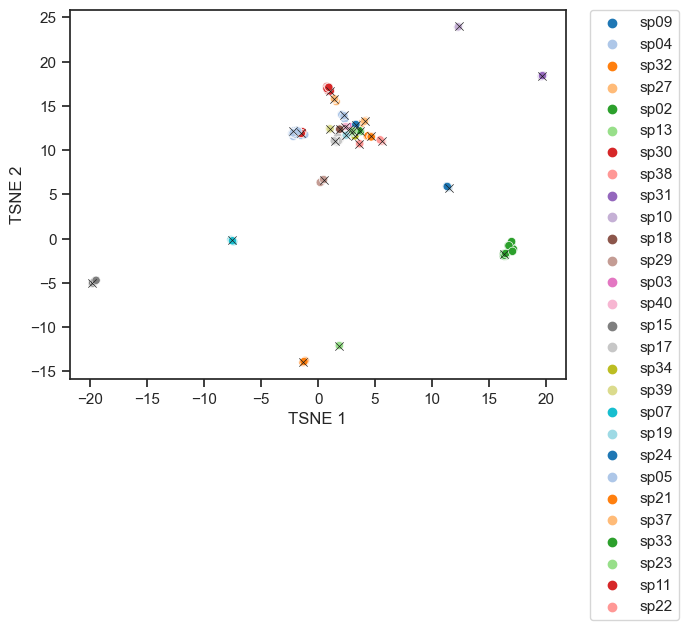

In [30]:
sns.scatterplot(data=XT,x="TSNE 1",y="TSNE 2", hue= bin_info.loc[Dist.index,"Species"],palette="tab20")

sns.scatterplot(data=XT.loc[XT.index.intersection(representatives)],x="TSNE 1",y="TSNE 2", 
#hue= bin_info.loc[representatives,"Species"],
color="k", legend=False,marker="x")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)